### Data Loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from pyod.models.copod import COPOD

In [10]:
df = pd.read_csv('Enter the full path of your dataset here')

### Exploratory Data Analysis

In [4]:
df.shape

(94746, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94746 entries, 0 to 94745
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   FullDate    94746 non-null  object
 1   Service_ID  63671 non-null  object
 2   KPI_ID      94746 non-null  object
 3   Value       94746 non-null  object
dtypes: object(4)
memory usage: 2.9+ MB


In [35]:
df.describe()

,FullDate,Service_ID,KPI_ID,Value
count,94746,63671,94746,94746
unique,45,776,7,1791
top,13/05/2024,Service_ID238,KPI_5,100.00%
freq,2702,280,39659,59072


2 Issues detected:
1. Service_ID has missing values
2. Value is interpreted as object instead of float64

### Handling Missing Values

In [11]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63671 entries, 0 to 94745
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   FullDate    63671 non-null  object
 1   Service_ID  63671 non-null  object
 2   KPI_ID      63671 non-null  object
 3   Value       63671 non-null  object
dtypes: object(4)
memory usage: 2.4+ MB


### Handling the Value Attribute

In [12]:
for i,value in enumerate(df['Value']):
  if(value.endswith('%')):
    df.iloc[i]['Value'] = np.float64(value[:-1])/100.0
df['Value'] = np.float64(df['Value'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63671 entries, 0 to 94745
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FullDate    63671 non-null  object 
 1   Service_ID  63671 non-null  object 
 2   KPI_ID      63671 non-null  object 
 3   Value       63671 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.4+ MB


### Adding Day Column

In [13]:
df['Day'] = pd.to_datetime(df['FullDate'],dayfirst=True).dt.day_name()
df

,FullDate,Service_ID,KPI_ID,Value,Day
0,04/04/2024,Service_ID2,KPI_1,0.5,Thursday
1,09/04/2024,Service_ID2,KPI_1,0.5,Tuesday
2,20/04/2024,Service_ID2,KPI_1,1.5,Saturday
3,01/04/2024,Service_ID3,KPI_1,0.5,Monday
4,02/04/2024,Service_ID3,KPI_1,0.9,Tuesday
...,...,...,...,...,...
94741,11/05/2024,Service_ID504,KPI_7,1.0,Saturday
94742,12/05/2024,Service_ID504,KPI_7,0.0,Sunday
94743,13/05/2024,Service_ID504,KPI_7,0.0,Monday
94744,14/05/2024,Service_ID504,KPI_7,1.0,Tuesday


### Adding Week Column

In [14]:
def get_week_number(date_str):
    date = pd.to_datetime(date_str, dayfirst=True)  # dayfirst=True for dd/mm/yyyy
    start_date = pd.to_datetime("01/04/2024", dayfirst=True)
    days_diff = (date - start_date).days
    week_number = days_diff // 7 + 1
    return week_number
df['Week'] = df['FullDate'].apply(get_week_number)
df

,FullDate,Service_ID,KPI_ID,Value,Day,Week
0,04/04/2024,Service_ID2,KPI_1,0.5,Thursday,1
1,09/04/2024,Service_ID2,KPI_1,0.5,Tuesday,2
2,20/04/2024,Service_ID2,KPI_1,1.5,Saturday,3
3,01/04/2024,Service_ID3,KPI_1,0.5,Monday,1
4,02/04/2024,Service_ID3,KPI_1,0.9,Tuesday,1
...,...,...,...,...,...,...
94741,11/05/2024,Service_ID504,KPI_7,1.0,Saturday,6
94742,12/05/2024,Service_ID504,KPI_7,0.0,Sunday,6
94743,13/05/2024,Service_ID504,KPI_7,0.0,Monday,7
94744,14/05/2024,Service_ID504,KPI_7,1.0,Tuesday,7


### Data Visualization

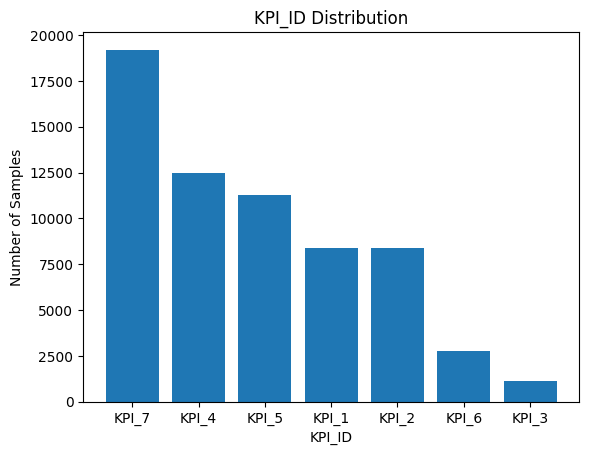

In [15]:
counts = df['KPI_ID'].value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel('KPI_ID')
plt.ylabel('Number of Samples')
plt.title('KPI_ID Distribution')
plt.show()


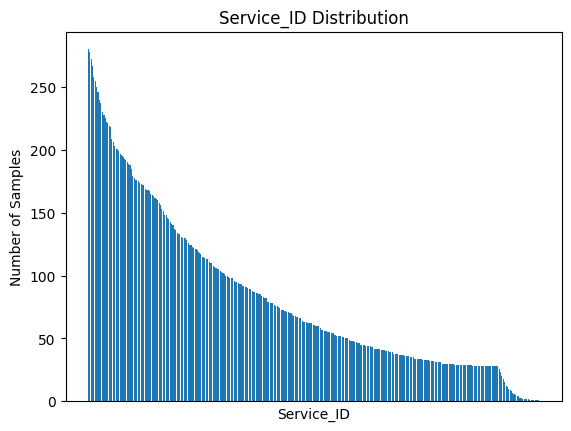

In [69]:
counts = df['Service_ID'].value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel('Service_ID')
plt.ylabel('Number of Samples')
plt.title('Service_ID Distribution')
plt.xticks([])
plt.show()


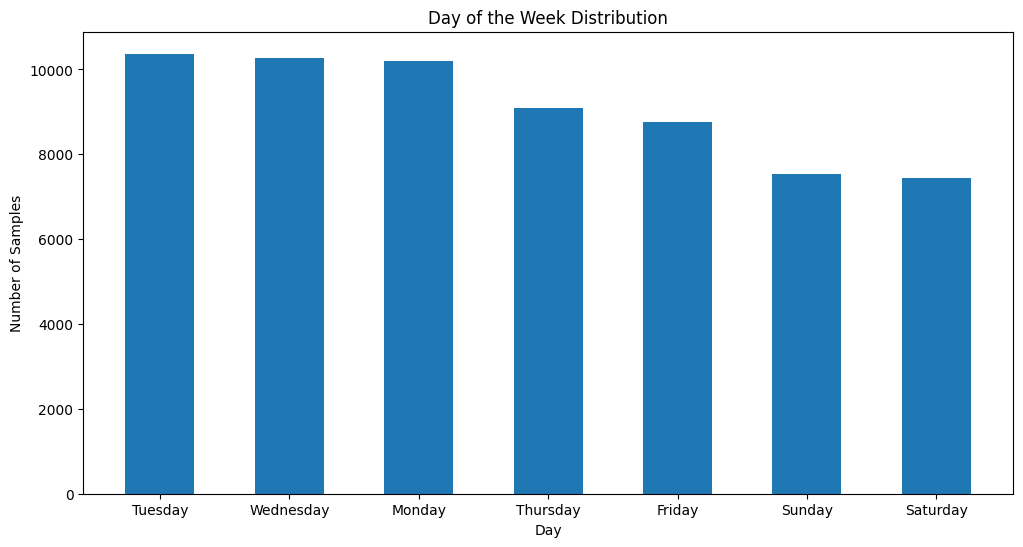

In [74]:
counts = df['Day'].value_counts()
labels = counts.index
values = counts.values
positions = np.arange(len(labels)) * 1.5
plt.figure(figsize=(12, 6))
plt.bar(positions, values)
plt.xlabel('Day')
plt.ylabel('Number of Samples')
plt.title('Day of the Week Distribution')
plt.xticks(positions, labels)
plt.show()

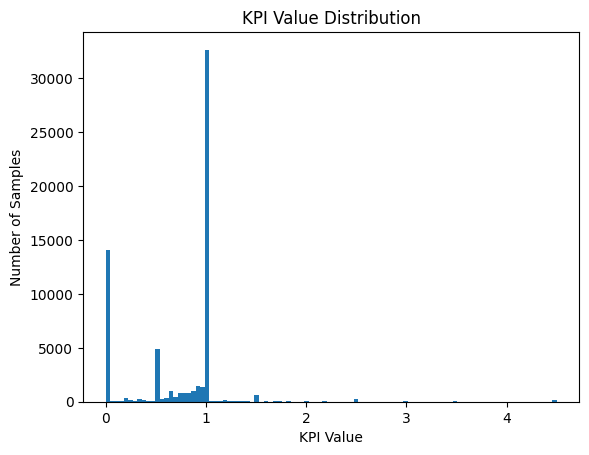

In [86]:
plt.hist(df['Value'],bins=100)
plt.title('KPI Value Distribution')
plt.xlabel('KPI Value')
plt.ylabel('Number of Samples')
plt.show()

### Grouping Service IDs and KPI IDs together

In [16]:
grouped =df.groupby(['Service_ID','KPI_ID'])
grouped_day = df.groupby(['Service_ID','KPI_ID','Day'])
grouped_week = df.groupby(['Service_ID','KPI_ID','Week'])

### Finding Outliers

In [37]:
def find_outliers_stats(group):
  values = group['Value']
  q1 = values.quantile(0.25)
  q3 = values.quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return group[(values < lower_bound) | (values > upper_bound)]
def find_outliers_copod(group):
    model = COPOD()
    # Reshape the 'Value' column to be 2-dimensional
    values = group['Value'].values.reshape(-1, 1)
    model.fit(values)
    #print(model.labels_) # The higher, the more likely to be an outlier
    return group[model.labels_ == 1]
def find_outliers_forest(group):
    model = IsolationForest()
    scaler = MinMaxScaler()
    # Reshape the 'Value' column to be 2-dimensional
    values = group['Value'].values.reshape(-1, 1)
    values = scaler.fit_transform(values)
    #print(model.labels_) # The higher, the more likely to be an outlier
    return group[model.fit_predict(values) == -1]

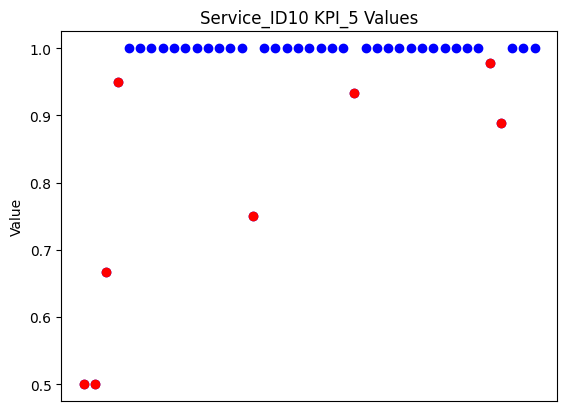

In [25]:
for j, i in grouped:
  outliers = find_outliers_stats(i)
  if not outliers.index.empty:
    plt.scatter(i['FullDate'],i['Value'],color='blue')
    plt.scatter(outliers['FullDate'],outliers['Value'],color='red')
    plt.title(i.iloc[0]['Service_ID']+' '+i.iloc[0]['KPI_ID']+' Values')
    plt.ylabel('Value')
    plt.xticks([])
    plt.show()
    break

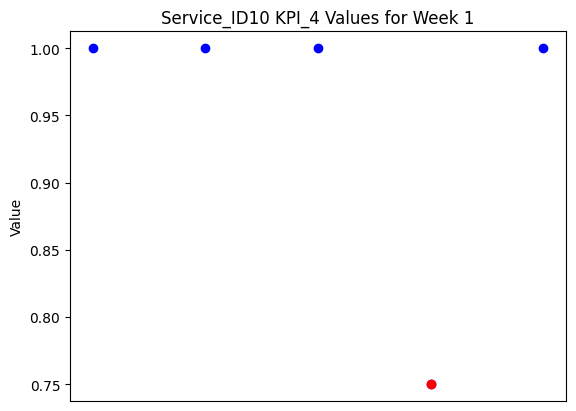

In [28]:
for j, i in grouped_week:
  outliers = find_outliers_stats(i)
  if not outliers.index.empty:
    plt.scatter(i['FullDate'],i['Value'],color='blue')
    plt.scatter(outliers['FullDate'],outliers['Value'],color='red')
    plt.title(i.iloc[0]['Service_ID']+' '+i.iloc[0]['KPI_ID']+' Values for Week '+str(i.iloc[0]['Week']))
    plt.ylabel('Value')
    plt.xticks([])
    plt.show()
    break

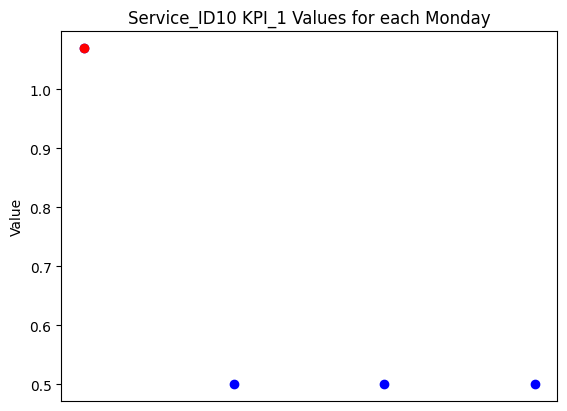

In [30]:
for j, i in grouped_day:
  outliers = find_outliers_stats(i)
  if not outliers.index.empty:
    plt.scatter(i['FullDate'],i['Value'],color='blue')
    plt.scatter(outliers['FullDate'],outliers['Value'],color='red')
    plt.title(i.iloc[0]['Service_ID']+' '+i.iloc[0]['KPI_ID']+' Values for each '+str(i.iloc[0]['Day']))
    plt.ylabel('Value')
    plt.xticks([])
    plt.show()
    break

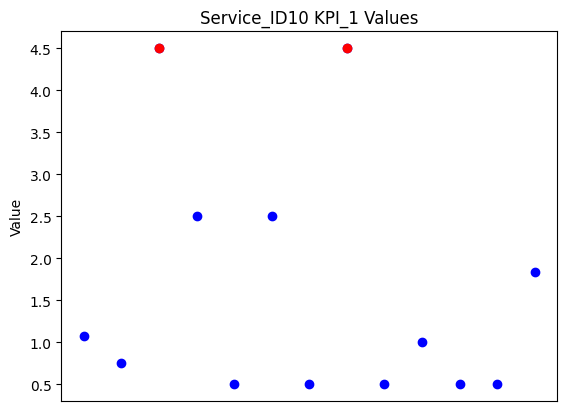

In [31]:
for j, i in grouped:
  outliers = find_outliers_copod(i)
  if not outliers.index.empty:
    plt.scatter(i['FullDate'],i['Value'],color='blue')
    plt.scatter(outliers['FullDate'],outliers['Value'],color='red')
    plt.title(i.iloc[0]['Service_ID']+' '+i.iloc[0]['KPI_ID']+' Values')
    plt.ylabel('Value')
    plt.xticks([])
    plt.show()
    break

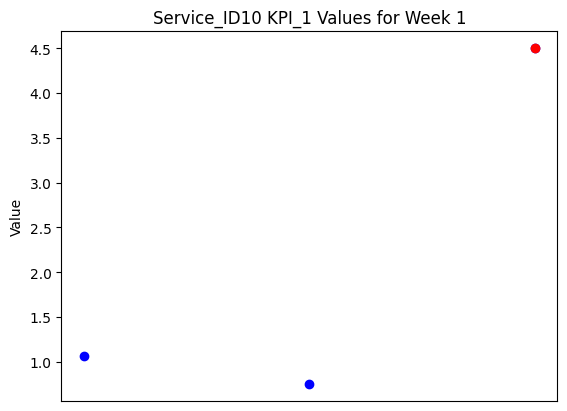

In [32]:
for j, i in grouped_week:
  outliers = find_outliers_copod(i)
  if not outliers.index.empty:
    plt.scatter(i['FullDate'],i['Value'],color='blue')
    plt.scatter(outliers['FullDate'],outliers['Value'],color='red')
    plt.title(i.iloc[0]['Service_ID']+' '+i.iloc[0]['KPI_ID']+' Values for Week '+str(i.iloc[0]['Week']))
    plt.ylabel('Value')
    plt.xticks([])
    plt.show()
    break

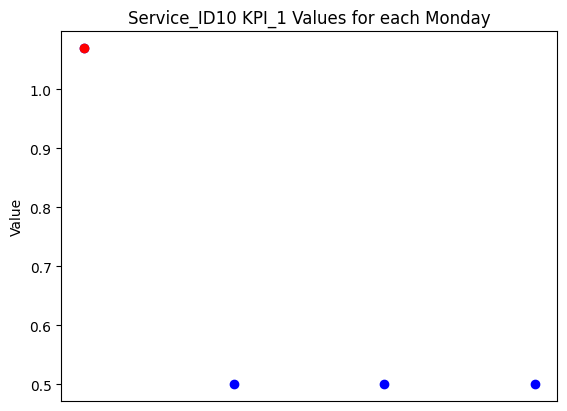

In [33]:
for j, i in grouped_day:
  outliers = find_outliers_copod(i)
  if not outliers.index.empty:
    plt.scatter(i['FullDate'],i['Value'],color='blue')
    plt.scatter(outliers['FullDate'],outliers['Value'],color='red')
    plt.title(i.iloc[0]['Service_ID']+' '+i.iloc[0]['KPI_ID']+' Values for each '+str(i.iloc[0]['Day']))
    plt.ylabel('Value')
    plt.xticks([])
    plt.show()
    break

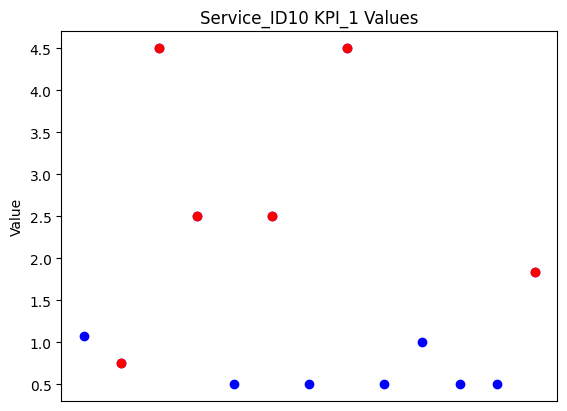

In [34]:
for j, i in grouped:
  outliers = find_outliers_forest(i)
  if not outliers.index.empty:
    plt.scatter(i['FullDate'],i['Value'],color='blue')
    plt.scatter(outliers['FullDate'],outliers['Value'],color='red')
    plt.title(i.iloc[0]['Service_ID']+' '+i.iloc[0]['KPI_ID']+' Values')
    plt.ylabel('Value')
    plt.xticks([])
    plt.show()
    break

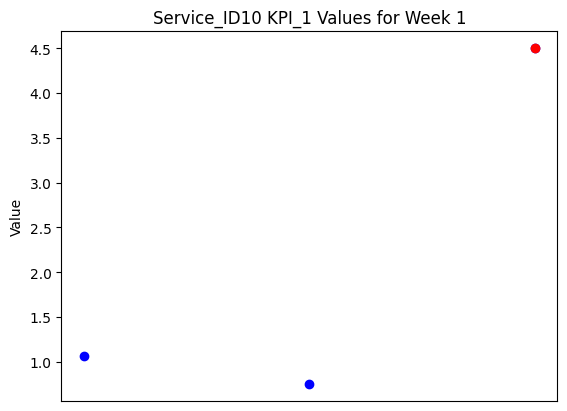

In [35]:
for j, i in grouped_week:
  outliers = find_outliers_forest(i)
  if not outliers.index.empty:
    plt.scatter(i['FullDate'],i['Value'],color='blue')
    plt.scatter(outliers['FullDate'],outliers['Value'],color='red')
    plt.title(i.iloc[0]['Service_ID']+' '+i.iloc[0]['KPI_ID']+' Values for Week '+str(i.iloc[0]['Week']))
    plt.ylabel('Value')
    plt.xticks([])
    plt.show()
    break

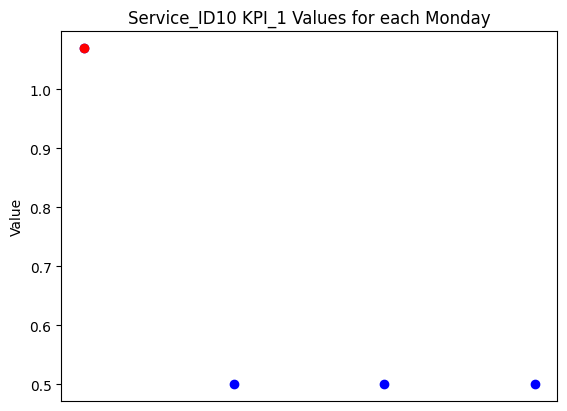

In [36]:
for j, i in grouped_day:
  outliers = find_outliers_forest(i)
  if not outliers.index.empty:
    plt.scatter(i['FullDate'],i['Value'],color='blue')
    plt.scatter(outliers['FullDate'],outliers['Value'],color='red')
    plt.title(i.iloc[0]['Service_ID']+' '+i.iloc[0]['KPI_ID']+' Values for each '+str(i.iloc[0]['Day']))
    plt.ylabel('Value')
    plt.xticks([])
    plt.show()
    break